## Import libraries

In [1]:
import os
from collections import defaultdict
import numpy as np
import PIL
from matplotlib import pyplot as plt

%matplotlib inline

from keras import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, RepeatVector, Concatenate, Activation
from keras.activations import softmax
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

from keras.optimizers import Adam

Using TensorFlow backend.


In [102]:
from keras.applications.vgg16 import VGG16

In [2]:
def load_image_list(filename):
    with open(filename,'r') as image_list_f: 
        return [line.strip() for line in image_list_f]

In [29]:
PATH = "flickr30k_images"

In [30]:
#read in captions
captions = load_image_list(os.path.join(PATH, 'results.csv'))

In [40]:
captions[6].split('|')

['10002456.jpg',
 ' 0',
 ' Several men in hard hats are operating a giant pulley system .']

In [31]:
##function to retrieve image names
def image_names(captions):
    images=[]
    for caption in captions[1:]:
        split_caption = caption.split('|')
        image_name = split_caption[0]
        images.append(image_name)
    
    images = set(images)
        
    return list(images)
        

In [32]:
images = image_names(captions)

In [51]:
#function to arrange captions in a dictionary for easy access
def parse_captions(captions,images):
    image_captions={}
    split_captions=[]
    for caption in captions[1:]:
        split_caption=caption.split('|')
        split_captions.append(split_caption)
    
    for image_name in images:
        caps=[]
        for details in split_captions:
            if image_name == details[0]:
                caps.append(details[-1])
        
        image_captions[image_name] = caps
    
    return image_captions
                

In [52]:
#parsed captions
image_captions = parse_captions(captions,images)

In [35]:
IMG_PATH='flickr30k_images/flickr30k_images'

 A crowd of people , all wearing raincoats with hoods pulled up , listening to a man wearing a red and blue raincoat , with curly brunette hair , speaks .
 A tour group wearing rain jackets and holding umbrellas are outside a barbed wire fence .
 A crowd of people are standing outside with coats and umbrellas because it is raining .
 A group of people are standing outside holding papers .
 A group of people is waiting in the rain .


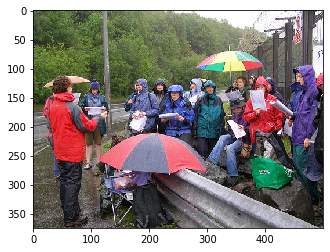

In [68]:
#view images and captions
picture = PIL.Image.open(os.path.join(IMG_PATH, images[1]))
plt.imshow(picture)
for item in image_captions[images[1]]:
    print(item)

In [69]:
np.asarray(picture).shape

(375, 500, 3)

In [70]:
np.asarray(picture)

array([[[ 59,  71,  57],
        [ 82,  86,  85],
        [ 73,  89,  78],
        ...,
        [231, 231, 243],
        [204, 203, 219],
        [254, 255, 255]],

       [[ 63,  73,  65],
        [ 73,  86,  77],
        [104, 118,  93],
        ...,
        [230, 227, 238],
        [220, 218, 231],
        [246, 246, 248]],

       [[ 61,  67,  63],
        [ 67,  90,  64],
        [109, 120,  86],
        ...,
        [226, 225, 233],
        [195, 195, 203],
        [112, 110, 123]],

       ...,

       [[ 75,  70,  50],
        [ 71,  71,  45],
        [ 58,  61,  34],
        ...,
        [ 93,  95,  73],
        [114, 115, 110],
        [113, 112, 130]],

       [[ 79,  67,  51],
        [ 59,  57,  36],
        [ 57,  59,  38],
        ...,
        [137, 140, 131],
        [127, 126, 142],
        [117, 117, 141]],

       [[ 64,  57,  47],
        [ 68,  69,  53],
        [ 90,  93,  76],
        ...,
        [133, 135, 148],
        [122, 119, 150],
        [124, 123, 139]]

In [71]:
#resize images to 299,299 for inceptionv3
def resize_image(image_name):
    image = PIL.Image.open(os.path.join(IMG_PATH, image_name))
    return np.asarray(image.resize((299,299))) / 255.0

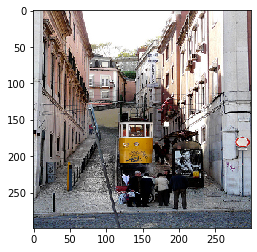

In [74]:
plt.imshow(resize_image(images[15]))

In [81]:
test_image = np.asarray(resize_image(images[15]))

### Load inceptionV3

In [78]:
feature_model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 16s 0us/step


In [79]:
feature_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [80]:
##Image encoder using inceptionv3
input_image = feature_model.input
output = feature_model.layers[-2].output
image_encoder = Model(input_image, output)

In [136]:
encoded_image = image_encoder.predict(np.array([test_image]))

In [138]:
encoded_image.shape

(1, 2048)

In [93]:
def image_generator(images):
    for image_name in images:
        img = resize_image(image_name)
        img = np.expand_dims(img, axis=0)
        yield img

In [95]:
enc_images = image_encoder.predict_generator(image_generator(images), steps=len(images), verbose=1)

31783/31783 [==============================] - 3812s 120ms/step


In [96]:
np.save('encoded_images.npy', enc_images)

In [100]:
len(enc_images[1])

2048

## Feature extraction with Places365 CNNs

In [127]:
from places import VGG16_Places365

In [144]:
#import urllib
#import numpy as np
from PIL import Image
#from cv2 import resize


model = VGG16_Places365(weights='places', include_top=True)

543088640/543085444 [==============================] - 120s 0us/step


In [145]:
model.summary()

Model: "vgg16-places365"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)   

In [146]:
##Image encoder using places365
inp = model.input
out = model.layers[-2].output
pl_enc = Model(inp, out)
enc_image = pl_enc.predict(np.array([test_image]))

In [147]:
enc_image.shape

(1, 4096)

In [139]:
def res_image(image_name):
    image = PIL.Image.open(os.path.join(IMG_PATH, image_name))
    return np.asarray(image.resize((224,224))) / 255.0

In [140]:
test_image = np.asarray(res_image(images[15]))

In [141]:
test_image.shape

(224, 224, 3)

In [149]:
enc_image[0]

array([0.5206727 , 0.        , 0.60470295, ..., 0.11761111, 0.37074035,
       0.2444047 ], dtype=float32)